Bessel's equation of order $n$ is the linear second order ordinary differential equation
\begin{equation}
    x^2y'' + xy' + (x^2 - n^2)y = 0.
\end{equation}
Bessel functions of the 1st kind, denoted  $J_n(x)$ are the solutions which are finite at $x = 0$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import jv, jvp
from math import factorial

# Bessel's equation:
# x^2y'' + xy' + (x^2 - n^2)y = 0.
# Bessel functions of the 1st kind J_n(x) are solutions finite at x = 0.

def bessel_ode(x, y, n):
    """
    Represents Bessel's 2nd order ODE as a system of two first-order ODEs.
    x^2y'' + xy' + (x^2 - n^2)y = 0
    y0 = y,  y1 = y'
    y0' = y1
    y1' = y'' = -(1/t)y1 - (1 - n^2/t^2)y0

    Args:
        x: The independent variable.
        y: An array [y0, y1].
        n: The order of the Bessel equation.
    Returns:
        An array [y0', y1'].
    """
    # Guard against division by zero at t=0.
    if x == 0:
        return np.array([0, 0])

    y0, y1 = y
    y0_dot = y1
    y1_dot = -(1/x) * y1 - (1 - n**2 / x**2) * y0
    return np.array([y0_dot, y1_dot])

In [ ]:
def get_bessel_J_via_ode(n, x_eval):
    '''
    Calculates J_n(x) by solving Bessel's differential equation.
    '''

    # Start at a small positive value away from x = 0.
    # Trying to solve at zero is not possible due to the 1/x singularity.
    x_start = 1e-6

    # To get the J_n(x) solution (not a mix with Y_n(x)), we need the
    # exact initial conditions. We can use SciPy's functions for this.
    # jv(n, x) gives the value J_n(x)
    # jvp(n, x) gives the derivative J'_n(x)
    y0 = np.array([jv(n, x_start), jvp(n, x_start)])

    # Define the time span for the solver
    t_span = np.array([x_start, x_eval[-1]])

    # Solve the ODE
    sol = solve_ivp(
        bessel_ode,
        t_span,
        y0,
        args=(n,),
        dense_output=True,
        t_eval=x_eval
    )
    return sol.y[0]

In [ ]:
def get_bessel_J_via_scipy(n, x_eval):
    '''
    Calculates J_(x) using the built-in, optimized SciPy function.
    '''
    return jv(n, x_eval)

In [ ]:
def get_bessel_J_via_series(n, x_eval, num_terms=50):
    '''
    Calculates J_n(x) by summing a truncated version of its series.
    Unstable but computationally efficient.

    Intermediate term growth: Individual terms in the series become large since
        the numerator grows faster than the denominator.
    Floating point overflow: The numerator can become larger than the maximum
        representable floating point number.
    Catestrophic cancellation: Alternating eries produces very large positive
        and negative terms that cancel each other, leading to large errors.
    '''
    def bessel_series_term(r, n, x):
        '''
        Calculates a single term in the series.
        Args:
            r: The order of the Bessel equation.
            n: The trunction index of the series.
            x: The independent variable.
        Returns:
            The value of the Bessel series term.
        '''
        try:
            numerator = ((-1)**r) * ((x / 2.0)**(2 * r + n))
            denominator = float(factorial(r) * factorial(n + r))
            return numerator / denominator
        except (OverflowError, ValueError):
            # Too large x.
            return np.nan

    total_sum = np.zeros_like(x_eval, dtype=float)
    for r in range(num_terms):
        terms = np.array([bessel_series_term(r, n, x) for x in x_eval])
        total_sum += terms

    return total_sum

Calculating J_0(x) from x=0 to 40.0...
Calculations complete.


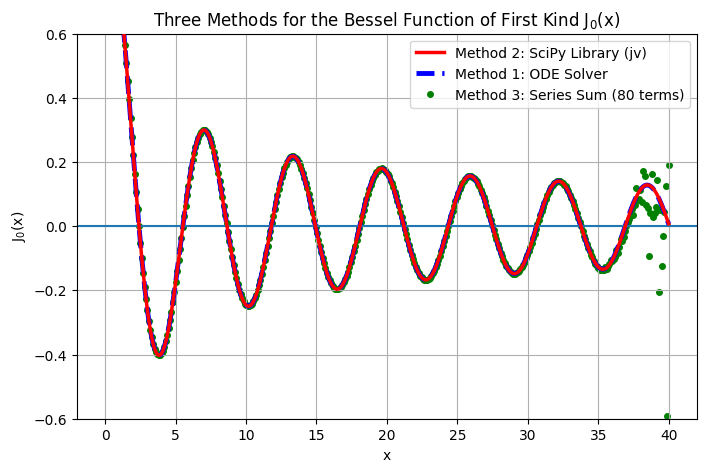

Calculating J_1(x) from x=0 to 40.0...
Calculations complete.


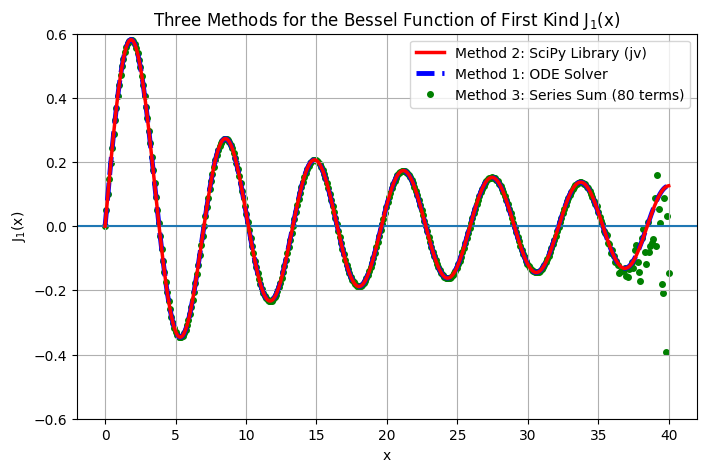

Calculating J_4(x) from x=0 to 40.0...
Calculations complete.


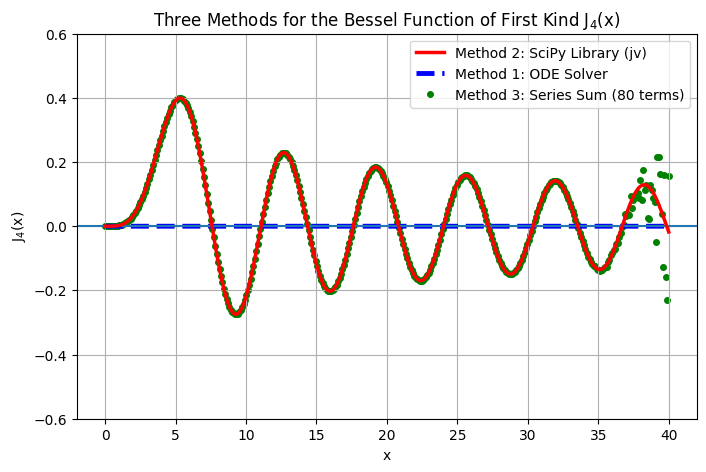

In [ ]:
# --- Parameters ---
ORDERS = [0, 1, 4]
X_MAX = 40.0
SERIES_TERMS = 80 # Number of terms for the series truncation
# Start slightly > 0 to avoid issues for the series and ODE
x_values = np.linspace(1e-6, X_MAX, 400)

for N_ORDER in ORDERS:
    # --- Execute all three methods ---
    print(f'Calculating J_{N_ORDER}(x) from x=0 to {X_MAX}...')
    y_ode = get_bessel_J_via_ode(N_ORDER, x_values)
    y_scipy = get_bessel_J_via_scipy(N_ORDER, x_values)
    y_series = get_bessel_J_via_series(N_ORDER, x_values, num_terms=SERIES_TERMS)
    print('Calculations complete.')

    # --- Plotting the results ---
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(x_values, y_scipy, 'r-', lw=2.5, label='Method 2: SciPy Library (jv)', zorder=3)
    ax.plot(x_values, y_ode, 'b--', lw=3.5, label='Method 1: ODE Solver', zorder=2)
    ax.plot(x_values, y_series, 'go', markersize=4, label=f'Method 3: Series Sum ({SERIES_TERMS} terms)', zorder=1)

    # --- Formatting ---
    ax.set_title(f'Three Methods for the Bessel Function of First Kind J$_{N_ORDER}$(x)')
    ax.set_xlabel('x')
    ax.set_ylabel(f'J$_{N_ORDER}$(x)')
    ax.axhline(0)
    ax.set_ylim(-0.6, 0.6)
    ax.legend()
    ax.grid(True)
    plt.show()